In [36]:
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
health_data = pd.read_csv('urlsmore/health/allHealthBody.csv')

In [3]:
pol_data = pd.read_csv('urlsmore/politics/allPolBody.csv')

In [4]:
heal_pol_data = pd.read_csv('urlsmore/medicalPolitics/allMedPolBody.csv')

In [5]:
health_data.head()

pol_data.head()

heal_pol_data.head()

health_data.drop('Unnamed: 0', axis=1, inplace=True)

pol_data.drop('Unnamed: 0', axis=1, inplace=True)

heal_pol_data.drop('Unnamed: 0', axis=1, inplace=True)

heal_pol_data.rename({'0': 'articles'}, axis=1, inplace=True)

pol_data.rename({'0': 'articles'}, axis=1, inplace=True)

health_data.rename({'0': 'articles'}, axis=1, inplace=True)

health_data["lable"]=1

heal_pol_data["lable"]=2

pol_data["lable"]=3

heal_pol_data

pol_data

health_data

df_col_merged = pd.concat([health_data, pol_data,heal_pol_data], ignore_index=True)

df_col_merged

df_col_merged.lable.value_counts()

3    4920
2    4920
1    4910
Name: lable, dtype: int64

In [6]:
df_col_merged

,articles,lable
0,"gender equality into practice, according to th...",1
1,Mobile Health Units (MHUs) have been ordered o...,1
2,"Provincial health officials are reporting 1,63...",1
3,"The firm owned 975,169 shares of the company’s...",1
4,in its most recent 13F filing with the Securit...,1
...,...,...
14745,"felt in every corner of the county, including ...",2
14746,"According to the 2019 Workforce Statistics, th...",2
14747,"felt in every corner of the county, including ...",2
14748,"RANDOLPH, NJ — Businesses in the Randolph area...",2


In [7]:
data = df_col_merged["articles"]

In [8]:
data

0        gender equality into practice, according to th...
1        Mobile Health Units (MHUs) have been ordered o...
2        Provincial health officials are reporting 1,63...
3        The firm owned 975,169 shares of the company’s...
4        in its most recent 13F filing with the Securit...
                               ...                        
14745    felt in every corner of the county, including ...
14746    According to the 2019 Workforce Statistics, th...
14747    felt in every corner of the county, including ...
14748    RANDOLPH, NJ — Businesses in the Randolph area...
14749    With artists on-site, performing outdoors and ...
Name: articles, Length: 14750, dtype: object

In [9]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

In [10]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [11]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

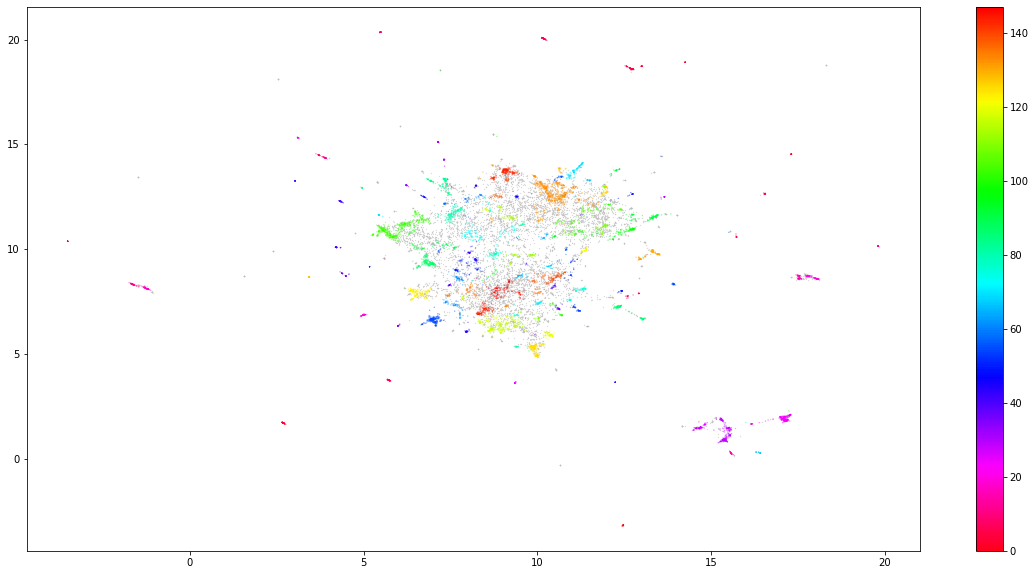

In [12]:

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [15]:
docs_df

,Doc,Topic,Doc_ID
0,NaN,-1,0
1,NaN,131,1
2,NaN,-1,2
3,NaN,24,3
4,NaN,24,4
...,...,...,...
14745,NaN,4,14745
14746,NaN,102,14746
14747,NaN,5,14747
14748,NaN,-1,14748


In [21]:
data

0        gender equality into practice, according to th...
1        Mobile Health Units (MHUs) have been ordered o...
2        Provincial health officials are reporting 1,63...
3        The firm owned 975,169 shares of the company’s...
4        in its most recent 13F filing with the Securit...
                               ...                        
14745    felt in every corner of the county, including ...
14746    According to the 2019 Workforce Statistics, th...
14747    felt in every corner of the county, including ...
14748    RANDOLPH, NJ — Businesses in the Randolph area...
14749    With artists on-site, performing outdoors and ...
Name: articles, Length: 14750, dtype: object

In [22]:
docs_df = pd.DataFrame(data)


In [24]:
docs_df['Topic'] = cluster.labels_


In [25]:
docs_df['Doc_ID'] = range(len(docs_df))



In [26]:
docs_df

,articles,Topic,Doc_ID
0,"gender equality into practice, according to th...",-1,0
1,Mobile Health Units (MHUs) have been ordered o...,131,1
2,"Provincial health officials are reporting 1,63...",-1,2
3,"The firm owned 975,169 shares of the company’s...",24,3
4,in its most recent 13F filing with the Securit...,24,4
...,...,...,...
14745,"felt in every corner of the county, including ...",4,14745
14746,"According to the 2019 Workforce Statistics, th...",102,14746
14747,"felt in every corner of the county, including ...",5,14747
14748,"RANDOLPH, NJ — Businesses in the Randolph area...",-1,14748


In [30]:
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'articles': ' '.join})

In [32]:


def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.articles.values, m=len(data))

In [34]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .articles
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "articles": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,7131
134,133,527
118,117,304
104,103,249
25,24,238
56,55,209
30,29,203
126,125,180
103,102,170
88,87,161


In [ ]:
for i in range(20):
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("articles", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'articles': ' '.join})

    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.articles.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)